In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import string
from scipy.optimize import curve_fit


In [2]:
# -------------------------
# Settings / paths
# -------------------------
dir_flux = "/burg/glab/users/rg3390/data/FLUXNET2015/"
fn_fluxlist = "fluxsite_info_metalist.xlsx"
dir_savefig = "/burg/home/rg3390/analysis/veg_air_T/"

dir_neg_H = "/burg/glab/users/rg3390/data/FLUXNET2015/"
fn_neg_H = 'df_neg_H_v10_rainbet12hrs_noZL.csv'
fn_neg_H_consec2hr = 'df_neg_H_consec2hr_v10_measured_only_rainbet12hrs_nozL.csv'
fn_neg_H_summary = 'site_valid_negH_summary_v10_measured_only_rainbet12hrs_nozL.csv'

fn_aridity = "site_aridity_index_yearly.csv"

# plotting knobs
plot_circle_scaler = 1
central_dot_area = 5
use_scaled_dots = False

color_map = {
    "DBF": "royalblue",
    "EBF": "gold",
    "ENF": "pink",
    "MF":  "mediumorchid",
}
fallback_color = "lightgray"  # for classes not listed above (e.g., DNF / Unknown)


In [3]:
# -------------------------
# Helpers
# -------------------------
def _lognormal_shape(x, A, mu, sigma, b):
    x = np.asarray(x)
    x = np.clip(x, 1e-9, None)
    return A * np.exp(-((np.log(x) - mu) ** 2) / (2.0 * sigma ** 2)) + b

def area_to_markersize(area_pts2: float) -> float:
    return float(np.sqrt(area_pts2))  # convert scatter area (pt^2) to marker size (pt)

# infer hour-of-day from common timestamp/hour columns
def _infer_hour_series(df):
    # direct hour-like columns
    for c in ["hour", "Hour", "HOUR", "HR", "Hr", "hour_local", "HOUR_LOCAL"]:
        if c in df.columns:
            h = pd.to_numeric(df[c], errors="coerce")
            if (h.between(0, 23)).sum() >= max(1, int(0.5 * len(h))):
                return h

    # try timestamps
    ts_candidates = ["TIMESTAMP_START", "TIMESTAMP_END", "TIMESTAMP",
                     "time", "datetime", "DateTime", "LOCAL_TIME", "date_time"]
    fmts = ["%Y%m%d%H%M", "%Y%m%d%H%M%S",
            "%Y-%m-%d %H:%M:%S", "%Y-%m-%d %H:%M",
            "%Y/%m/%d %H:%M", "%m/%d/%Y %H:%M", "%d/%m/%Y %H:%M",
            "%Y-%m-%dT%H:%M:%S", "%Y-%m-%dT%H:%M:%SZ"]
    for c in ts_candidates:
        if c in df.columns:
            s = df[c].astype(str).str.strip()
            dt = None
            for fmt in fmts:
                dt_try = pd.to_datetime(s, format=fmt, errors="coerce")
                if dt_try.notna().sum() >= int(0.5 * len(s)):
                    dt = dt_try
                    break
            if dt is None:
                dt = pd.to_datetime(s, errors="coerce", utc=False)
                if dt.notna().sum() < int(0.5 * len(s)):
                    continue
            return dt.dt.hour

    return pd.Series(np.nan, index=df.index)


In [13]:
# =========================
# MAP data (site list)
# =========================
df_sitelist = pd.read_excel(os.path.join(dir_flux, fn_fluxlist))
forest_site_mask = (
    (df_sitelist["source"].isin(["ICOS","AmeriFlux","FLUXNET","Ozflux","LBA-ECO"])) &
    (df_sitelist["IGBP"].isin(["EBF","ENF","DBF","DNF","MF"])) &
    ((df_sitelist["year_end"] - df_sitelist["year_start"] + 1) >= 3)
)
df_forest_sitelist = df_sitelist[forest_site_mask].reset_index(drop=True)
total_site = len(df_forest_sitelist)
print(f"total sites n = {total_site}")

df_forest_sitelist["total_year"] = df_forest_sitelist["year_end"] - df_forest_sitelist["year_start"] + 1
sum_all_year = np.sum(df_forest_sitelist["total_year"])
print(f"all observational year = {sum_all_year}")

# Keep only rows with valid coordinates
required_cols = {"LOCATION_LAT", "LOCATION_LONG", "total_year"}
assert required_cols.issubset(df_forest_sitelist.columns), f"Missing columns: {required_cols - set(df_forest_sitelist.columns)}"
df_plot = df_forest_sitelist.dropna(subset=["LOCATION_LAT", "LOCATION_LONG"]).copy()

# Edge color by IGBP (fallback)
df_plot["edge_color"] = df_plot["IGBP"].map(color_map).fillna(fallback_color)

# Marker area by total_year (scatter 's' is area in pt^2)
min_year = int(df_plot["total_year"].min())
max_year = int(df_plot["total_year"].max())
min_area, max_area = 40, 400
if min_year == max_year:
    df_plot["marker_size"] = ((min_area + max_area) / 2.0) * plot_circle_scaler
else:
    df_plot["marker_size"] = np.interp(
        df_plot["total_year"], [min_year, max_year], [min_area, max_area]
    ) * plot_circle_scaler

# how many sites in mid- and high- lat (lat >= 30 S or lat >= 30 N)
site_mid_high_lat = (abs(df_forest_sitelist["LOCATION_LAT"].values) >= 30)
print(f"number of site in mid- and high- latitude = {sum(site_mid_high_lat)}")
print(f"% site in mid- and high- latitude = {sum(site_mid_high_lat)/total_site}")

total sites n = 158
all observational year = 1633.0
number of site in mid- and high- latitude = 137
% site in mid- and high- latitude = 0.8670886075949367


In [19]:
# =========================
# STATS data (neg H, aridity, canopy)
# =========================
# ---- Summary for per-site % negH
df_neg_H_summary = pd.read_csv(dir_neg_H + fn_neg_H_summary)

for col in ["count_neg_H_2hr", "count_valid"]:
    df_neg_H_summary[col] = pd.to_numeric(df_neg_H_summary[col], errors="coerce")

df_neg_H_summary["pct_negH_2hr"] = np.where(
    df_neg_H_summary["count_valid"] > 0,
    100.0 * df_neg_H_summary["count_neg_H_2hr"].astype(float) / df_neg_H_summary["count_valid"].astype(float),
    np.nan
)
df_neg_H_summary["site_IGBP"] = df_neg_H_summary["site_IGBP"].fillna("Unknown").astype(str)
total_neg_H_hour = np.sum(df_neg_H_summary["count_neg_H_2hr"])

# violin prep (sort groups by median)
data_by_grp, labels, counts, medians = [], [], [], []
for igbp, s in df_neg_H_summary.groupby("site_IGBP")["pct_negH_2hr"]:
    vals = s.dropna().values
    if len(vals) == 0:
        continue
    data_by_grp.append(vals); labels.append(igbp)
    counts.append(len(vals)); medians.append(np.median(vals))
order = np.argsort(medians)[::-1]
data_by_grp = [data_by_grp[i] for i in order]
labels_sorted = [labels[i] for i in order]
counts_sorted = [counts[i] for i in order]
xtick_labels_violin = [f"{g}\n(n={n})" for g, n in zip(labels_sorted, counts_sorted)]

# Medians in the same sorted order used by the violin
medians_sorted = [np.nanmedian(arr) for arr in data_by_grp]

print("Figure (c) medians of % neg. H by IGBP:")
for lab, n, m in zip(labels_sorted, counts_sorted, medians_sorted):
    print(f"  {lab}: median = {m:.2f}%  (n={n})")

overall_median = np.nanmedian(df_neg_H_summary["pct_negH_2hr"].values)
print(f"\nOverall median across all sites: {overall_median:.2f}%")


# ---- Strong neg H (5th pctile)
df_neg_H_consec2hr = pd.read_csv(dir_neg_H + fn_neg_H_consec2hr).copy()
df_neg_H_consec2hr["IGBP"] = df_neg_H_consec2hr["IGBP"].fillna("Unknown").astype(str)
df_neg_H_consec2hr["H_flux"] = pd.to_numeric(df_neg_H_consec2hr["H_flux"], errors="coerce")
h_thresh = np.nanpercentile(df_neg_H_consec2hr["H_flux"], 5)
print(f"strong neg. H threshold = {np.round(h_thresh, 2)} W/m2")
print(f"mean neg. H = {np.round(np.sum(df_neg_H_consec2hr['H_flux'])/total_neg_H_hour, 2)} W/m2")

# global denominator for % strong in all negH
den_all = pd.to_numeric(df_neg_H_summary["count_neg_H_2hr"], errors="coerce").sum(min_count=1)

strong = df_neg_H_consec2hr.loc[df_neg_H_consec2hr["H_flux"] <= h_thresh]
strong_counts = (
    strong.groupby("IGBP", dropna=False)
          .size()
          .rename("count_strong")
          .reset_index()
)
if pd.notna(den_all) and den_all > 0:
    strong_counts["pct"] = 100.0 * strong_counts["count_strong"] / den_all
else:
    strong_counts["pct"] = np.nan

order_pref = ["DBF", "EBF", "MF", "ENF"]
present_pref = [g for g in order_pref if g in strong_counts["IGBP"].astype(str).unique()]
pref_df = (
    strong_counts[strong_counts["IGBP"].isin(present_pref)]
    .set_index("IGBP")
    .loc[present_pref]
    .reset_index()
)
others_df = strong_counts[~strong_counts["IGBP"].isin(present_pref)]
strong_counts = pd.concat([pref_df, others_df], ignore_index=True)


# consecutive 2+ hr neg-H hour-of-day distribution by PFT
df_hours = df_neg_H_consec2hr.copy()
df_hours["hour_of_day"] = _infer_hour_series(df_hours)
df_hours = df_hours[pd.to_numeric(df_hours["H_flux"], errors="coerce") < 0]
df_hours = df_hours[df_hours["hour_of_day"].notna()].copy()
df_hours["hour_of_day"] = df_hours["hour_of_day"].astype(int).clip(0, 23)

hours = np.arange(24)
pfts_for_plot = [p for p in ["DBF", "EBF", "MF", "ENF"] if p in df_hours["IGBP"].unique()]
pfts_for_plot += [p for p in sorted(df_hours["IGBP"].unique()) if p not in pfts_for_plot]

hour_pct_by_pft, counts_by_pft = {}, {}
for p in pfts_for_plot:
    cnt = (df_hours.loc[df_hours["IGBP"] == p, "hour_of_day"]
                    .value_counts()
                    .reindex(hours, fill_value=0))
    total = int(cnt.sum())
    counts_by_pft[p] = total
    hour_pct_by_pft[p] = 100.0 * cnt / total if total > 0 else pd.Series(0.0, index=hours)




# ---- Canopy height box overlay support
try:
    df_fluxlist = pd.read_excel(dir_flux + fn_fluxlist, engine="openpyxl")
except Exception:
    df_fluxlist = pd.read_excel(dir_flux + fn_fluxlist)
df_fluxlist["IGBP"] = df_fluxlist["IGBP"].astype(str)
df_fluxlist["canopy_h"] = pd.to_numeric(df_fluxlist["canopy_h"], errors="coerce")
df_fluxlist = df_fluxlist.dropna(subset=["canopy_h"])

mean_canopy = df_fluxlist.groupby("IGBP", dropna=False)["canopy_h"].mean()
print(f"mean canopy height = {mean_canopy}")

igbp_order_b = list(strong_counts["IGBP"].astype(str))
n_canopy_by_igbp = (
    df_fluxlist.groupby("IGBP")["canopy_h"]
               .count()
               .reindex(igbp_order_b)
               .fillna(0)
               .astype(int)
)
xtick_labels_b = [f"{g}\n(n={int(n_canopy_by_igbp.loc[g])})" for g in igbp_order_b]




# ---- Aridity vs %negH scatter
df_arid = pd.read_csv(dir_neg_H + fn_aridity)
df_arid["P_PET"] = pd.to_numeric(df_arid["P_PET"], errors="coerce")

df_arid_mean = (
    df_arid.groupby(["site_ID", "site_IGBP"], dropna=False)["P_PET"]
           .mean()
           .rename("mean_P_over_PET")
           .reset_index()
)
df_arid_mean.loc[df_arid_mean["mean_P_over_PET"] > 2.5, "mean_P_over_PET"] = np.nan
negH_pct = df_neg_H_summary[["site_ID", "site_IGBP", "pct_negH_2hr"]].copy()

df_scatter = df_arid_mean.merge(negH_pct, on="site_ID", suffixes=("_arid", "_negH"), how="inner")
if "site_IGBP_arid" in df_scatter.columns and "site_IGBP_negH" in df_scatter.columns:
    df_scatter["site_IGBP"] = np.where(df_scatter["site_IGBP_arid"].notna(),
                                       df_scatter["site_IGBP_arid"],
                                       df_scatter["site_IGBP_negH"])
    df_scatter.drop(columns=["site_IGBP_arid", "site_IGBP_negH"], inplace=True)
elif "site_IGBP_arid" in df_scatter.columns:
    df_scatter.rename(columns={"site_IGBP_arid": "site_IGBP"}, inplace=True)
elif "site_IGBP_negH" in df_scatter.columns:
    df_scatter.rename(columns={"site_IGBP_negH": "site_IGBP"}, inplace=True)

plot_AI_df = df_scatter.dropna(subset=["mean_P_over_PET", "pct_negH_2hr"]).copy()
print(plot_AI_df)





# ---- Binning for SWdn, Ta, RH
SWdw_bin_edges = np.arange(0, 1200, 100)
bin_index_SWdw = pd.IntervalIndex.from_breaks(SWdw_bin_edges, closed="left")

dfB = df_neg_H_consec2hr.copy()
dfB["H_flux"]  = pd.to_numeric(dfB["H_flux"], errors="coerce")
dfB["SW_IN_F"] = pd.to_numeric(dfB["SW_IN_F"], errors="coerce")
dfB["is_strong"] = dfB["H_flux"] <= h_thresh
dfB["SW_bin"] = pd.cut(dfB["SW_IN_F"], bins=bin_index_SWdw, include_lowest=True, right=False)

counts_SWdw = (
    dfB.groupby(["SW_bin", "is_strong"], observed=True)
       .size()
       .unstack("is_strong", fill_value=0)
       .reindex(index=bin_index_SWdw, fill_value=0)
       .reindex(columns=[False, True], fill_value=0)
)
totals_SWdw = counts_SWdw.sum(axis=1).replace(0, np.nan)
pct_other_SWdw  = (100.0 * counts_SWdw[False] / totals_SWdw).fillna(0.0).values
pct_strong_SWdw = (100.0 * counts_SWdw[True]  / totals_SWdw).fillna(0.0).values

Ta_bin_edges = np.arange(5, 50, 5)
bin_index_Ta = pd.IntervalIndex.from_breaks(Ta_bin_edges, closed="left")
dfB["TA_F"] = pd.to_numeric(dfB["TA_F"], errors="coerce")
dfB["Ta_bin"] = pd.cut(dfB["TA_F"], bins=bin_index_Ta, include_lowest=True, right=False)
counts_Ta = (
    dfB.groupby(["Ta_bin", "is_strong"], observed=True)
       .size()
       .unstack("is_strong", fill_value=0)
       .reindex(index=bin_index_Ta, fill_value=0)
       .reindex(columns=[False, True], fill_value=0)
)
totals_Ta = counts_Ta.sum(axis=1).replace(0, np.nan)
pct_other_Ta  = (100.0 * counts_Ta[False] / totals_Ta).fillna(0.0).values
pct_strong_Ta = (100.0 * counts_Ta[True]  / totals_Ta).fillna(0.0).values

RH_bin_edges = np.arange(0, 101, 10)
bin_index_RH = pd.IntervalIndex.from_breaks(RH_bin_edges, closed="left")
dfB["RH"] = pd.to_numeric(dfB["RH"], errors="coerce")
dfB["RH_bin"] = pd.cut(dfB["RH"], bins=bin_index_RH, include_lowest=True, right=False)
counts_RH = (
    dfB.groupby(["RH_bin", "is_strong"], observed=True)
       .size()
       .unstack("is_strong", fill_value=0)
       .reindex(index=bin_index_RH, fill_value=0)
       .reindex(columns=[False, True], fill_value=0)
)
totals_RH = counts_RH.sum(axis=1).replace(0, np.nan)
pct_other_RH  = (100.0 * counts_RH[False] / totals_RH).fillna(0.0).values
pct_strong_RH = (100.0 * counts_RH[True]  / totals_RH).fillna(0.0).values



Figure (c) medians of % neg. H by IGBP:
  DBF: median = 0.40%  (n=41)
  MF: median = 0.27%  (n=10)
  EBF: median = 0.17%  (n=22)
  ENF: median = 0.04%  (n=69)

Overall median across all sites: 0.15%
strong neg. H threshold = -77.43 W/m2
mean neg. H = -30.06 W/m2
mean canopy height = IGBP
CRO     1.641346
CSH     1.350000
DBF    19.430291
DNF    19.600000
EBF    28.123791
ENF    14.322341
GRA     0.520925
MF     27.485714
OSH     2.210000
SAV     8.005000
SNO     0.050000
WET     2.629210
WSA    10.740000
Name: canopy_h, dtype: float64
    site_ID  mean_P_over_PET  pct_negH_2hr site_IGBP
0    AR-SLu         0.202636      0.000000        MF
1    AR-Vir         0.752006      0.000000       ENF
2    AU-Cow         2.065585      0.813732       EBF
3    AU-Cum         0.462833      0.069735       EBF
4    AU-Rob         0.969197      0.126550       EBF
..      ...              ...           ...       ...
145  US-xTR         0.559106      0.358720       DBF
146  US-xUK         0.648798      3

Saved png: fig_1_site_map_neg_H_stats.png


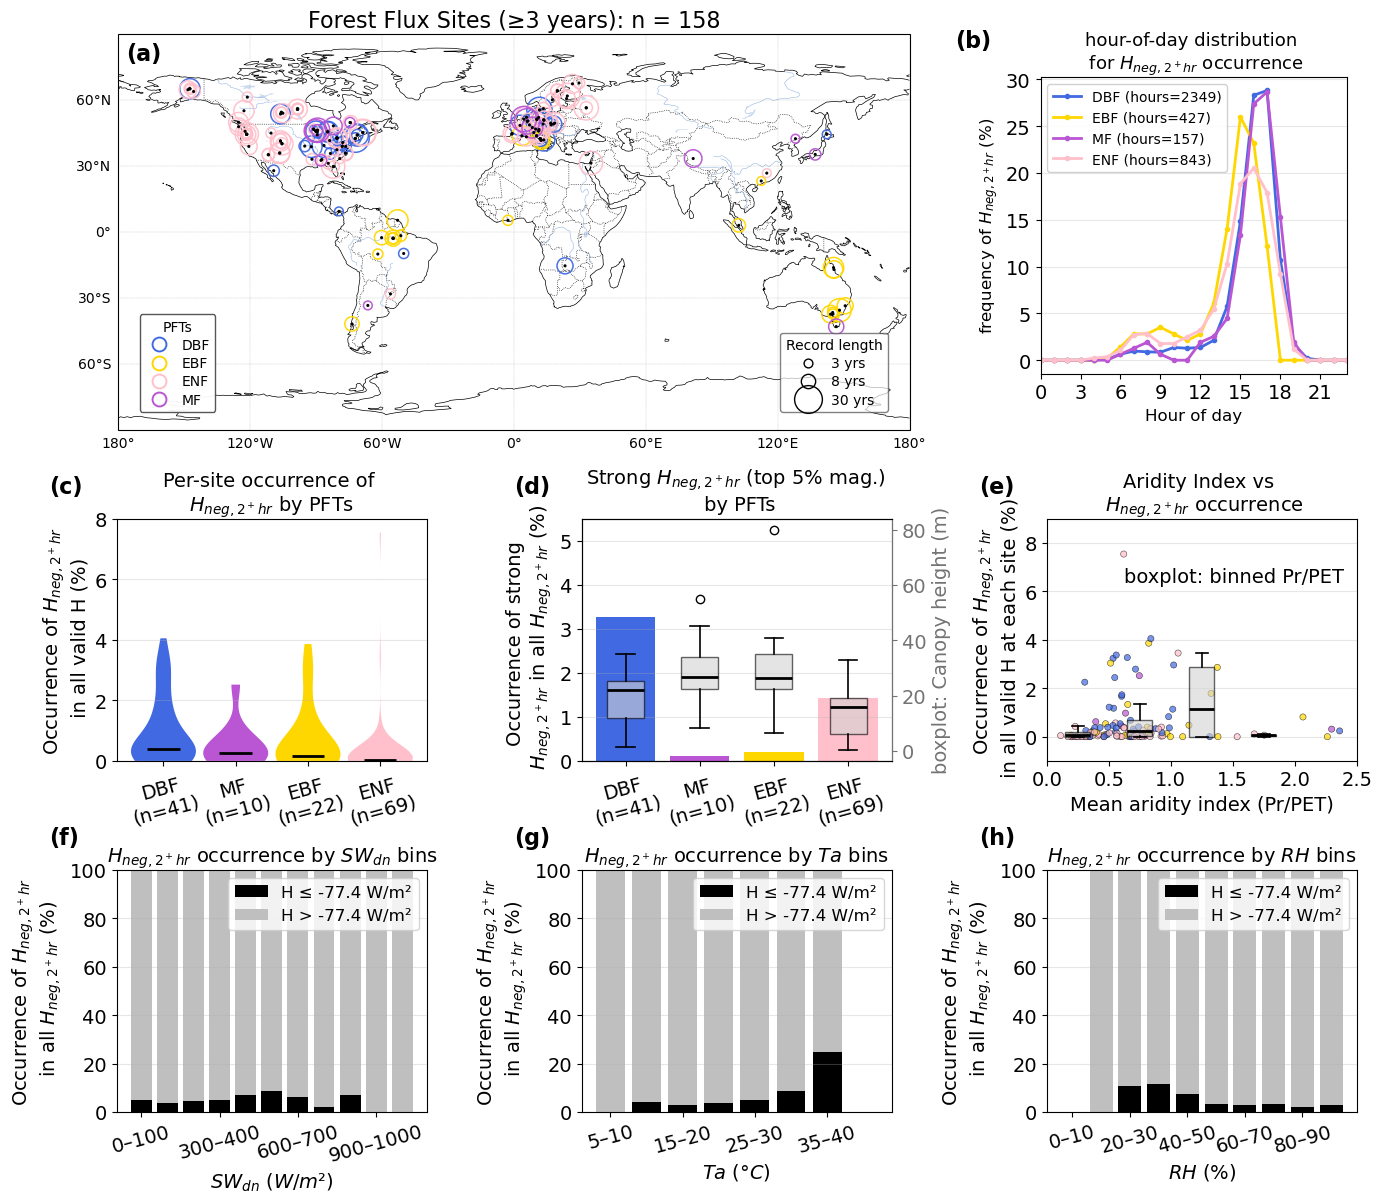

In [22]:
# =========================
# FIGURE: top map; bottom 2×3 stats
# =========================
fig = plt.figure(figsize=(16, 14))
outer = gridspec.GridSpec(
    nrows=2, ncols=1, height_ratios=[1.2, 1.8],
    hspace=0.18
)

# --- Top row: MAP (spans full width)
### CHANGED: Top row is now a 1×3 grid; map spans first two cols, hour plot in third
top = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=outer[0], wspace=0.28)

# map spans ax[0,0] + ax[0,1]
ax_map = fig.add_subplot(top[0, :2], projection=ccrs.PlateCarree())
ax_map.set_global()
ax_map.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax_map.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)
ax_map.add_feature(cfeature.LAKES, alpha=0.5)
ax_map.add_feature(cfeature.RIVERS, linewidth=0.4)

gl = ax_map.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,
                      linewidth=0.3, color="0.65", alpha=0.7, linestyle="--")
gl.top_labels = False
gl.right_labels = False

# map markers (unchanged)
for igbp, group in df_plot.groupby("IGBP"):
    ax_map.scatter(group["LOCATION_LONG"].values, group["LOCATION_LAT"].values,
                   s=group["marker_size"].values, transform=ccrs.PlateCarree(),
                   facecolors="none", edgecolors=group["edge_color"].iloc[0],
                   linewidths=1.1, alpha=0.95, zorder=5)
    s_dots = (np.clip(group["marker_size"].values * 0.0001, 12, 60)
              if use_scaled_dots else central_dot_area)
    ax_map.scatter(group["LOCATION_LONG"].values, group["LOCATION_LAT"].values,
                   s=s_dots, transform=ccrs.PlateCarree(),
                   facecolors="k", edgecolors="none", alpha=1.0, zorder=6)

ax_map.set_title(f"Forest Flux Sites (≥3 years): n = {len(df_plot)}", fontsize=16, pad=5)

# legends
present = list(df_plot["IGBP"].unique())
ordered_classes = [k for k in color_map if k in present]
has_other = any((c not in color_map) for c in present)

handles_color = [Line2D([0],[0], marker="o", linestyle="None", markerfacecolor="none",
                         markeredgecolor=color_map[cls], markeredgewidth=1.4,
                         markersize=10, label=cls) for cls in ordered_classes]
if has_other:
    handles_color.append(Line2D([0],[0], marker="o", linestyle="None",
                                markerfacecolor="none", markeredgecolor=fallback_color,
                                markeredgewidth=1.4, markersize=10, label="Other"))
leg1 = ax_map.legend(handles=handles_color, title="PFTs",
                     loc="lower left", bbox_to_anchor=(0.02, 0.03),
                     bbox_transform=ax_map.transAxes,
                     frameon=True, edgecolor="0.3", framealpha=0.95,
                     borderaxespad=0.4, labelspacing=0.3, handletextpad=0.6)
ax_map.add_artist(leg1)

def year_to_area(y):
    if min_year == max_year:
        return (min_area + max_area) / 2.0 * plot_circle_scaler
    return float(np.interp(y, [min_year, max_year], [min_area, max_area]) * plot_circle_scaler)

legend_years = [min_year] if (min_year == max_year) else sorted({min_year, int(np.median(df_plot["total_year"])), max_year})
handles_size = [Line2D([0],[0], marker="o", linestyle="None", markerfacecolor="none",
                       markeredgecolor="k", markeredgewidth=1.0,
                       markersize=area_to_markersize(year_to_area(y)),
                       label=f"{y} yr" if y == 1 else f"{y} yrs") for y in legend_years]
leg2 = ax_map.legend(handles=handles_size, title="Record length",
                     loc="lower right", bbox_to_anchor=(0.98, 0.03),
                     bbox_transform=ax_map.transAxes,
                     frameon=True, edgecolor="0.3", framealpha=0.70,
                     borderaxespad=0.4, labelspacing=0.3, handletextpad=0.6)

ax_map.text(0.01, 0.98, "(a)", transform=ax_map.transAxes,
            fontsize=16, fontweight="bold", va="top", ha="left")

# top-right panel: hourly distribution of consecutive 2+ hr neg-H, one line per PFT
ax_hour = fig.add_subplot(top[0, 2])
for p in pfts_for_plot:
    series = hour_pct_by_pft[p].reindex(hours, fill_value=0.0)
    ax_hour.plot(hours, series.values, marker="o", linewidth=2, markersize=3,
                 color=color_map.get(p, "0.5"), label=f"{p} (hours={counts_by_pft[p]})")
ax_hour.set_xlim(0, 23); ax_hour.set_xticks(np.arange(0, 24, 3))
ax_hour.set_xlabel("Hour of day", fontsize=12)
ax_hour.set_ylabel("frequency of $H_{neg,2^+hr}$ (%)", fontsize=12)
ax_hour.set_title("hour-of-day distribution \n for $H_{neg,2^+hr}$ occurrence", fontsize=13)
ax_hour.grid(axis="y", alpha=0.3)
ax_hour.tick_params(axis="both", labelsize=14)
ax_hour.legend(frameon=True, framealpha=0.9, fontsize=10, loc="upper left")
# shrink & lift a bit so it doesn’t collide with the bottom row
pos = ax_hour.get_position()
ax_hour.set_position([pos.x0+0.02, pos.y0 + 0.04, pos.width*0.88, pos.height*0.75])
ax_hour.text(-0.28, 1.16, "(b)", transform=ax_hour.transAxes,
              fontsize=16, fontweight="bold", va="top", ha="left")


# --- Bottom block: 2×3 stats
inner = gridspec.GridSpecFromSubplotSpec(
    2, 3, subplot_spec=outer[1],
    wspace=0.5,   # was 0.25
    hspace=0.45    # was 0.28
)
axes_stats = np.array([
    [fig.add_subplot(inner[0, 0]), fig.add_subplot(inner[0, 1]), fig.add_subplot(inner[0, 2])],
    [fig.add_subplot(inner[1, 0]), fig.add_subplot(inner[1, 1]), fig.add_subplot(inner[1, 2])]
])

# (c) violin: per-site % negH by PFTs (sorted)
ax = axes_stats[0, 0]
xpos = np.arange(1, len(data_by_grp) + 1)
vp = ax.violinplot(
    data_by_grp, positions=xpos, points=50,
    showmeans=False, showmedians=True, showextrema=False, widths=0.9
)
for i, body in enumerate(vp["bodies"]):
    grp = labels_sorted[i]
    face = color_map.get(grp, "lightgray")
    body.set_facecolor(face); body.set_edgecolor("none"); body.set_alpha(1)
if "cmedians" in vp:
    try:
        vp["cmedians"].set_color("black"); vp["cmedians"].set_linewidth(2.0)
    except Exception:
        pass
ax.set_xticks(xpos)
ax.set_xticklabels(xtick_labels_violin, rotation=15, ha="center", fontsize=12)
ax.set_ylabel("Occurrence of $H_{neg,2^+hr}$ \n in all valid H (%)", fontsize=14)
ax.set_title("Per-site occurrence of \n$H_{neg,2^+hr}$ by PFTs", fontsize=14)
ax.set_ylim(0, 8)
ax.grid(axis="y", alpha=0.3)
ax.tick_params(axis="both", labelsize=14)
ax.text(-0.22, 1.18, "(c)", transform=ax.transAxes, fontsize=16, fontweight="bold", va="top", ha="left")

# (d) bars: strong negH share + (grey) canopy height boxplots on twin y-axis
# prepare x order from (b)
order_from_b = labels_sorted                 # IGBP order used in (b)
n_from_b     = counts_sorted                 # sample sizes used in (b)
igbp_to_n    = dict(zip(order_from_b, n_from_b))

# Reindex strong_counts to follow (b)'s order; fill missing groups with zeros
strong_counts = (
    strong_counts.set_index("IGBP")
                 .reindex(order_from_b)
                 .assign(
                     count_strong=lambda df: df["count_strong"].fillna(0).astype(int),
                     pct=lambda df: df["pct"].fillna(0.0).astype(float),
                 )
                 .reset_index()
)

# X-tick labels for (c) that show the SAME n as (b)
xtick_labels_c = [f"{g}\n(n={igbp_to_n.get(g, 0)})" for g in order_from_b]

# plot (d2)
axb = axes_stats[0, 1]
x = np.arange(len(order_from_b))
bar_colors = [color_map.get(g, "lightgray") for g in order_from_b]
axb.bar(x, strong_counts["pct"].values, color=bar_colors, edgecolor="none")
axb.set_xticks(x)
axb.set_xticklabels(xtick_labels_c, rotation=0, ha="center", fontsize=12)
axb.set_ylabel("Occurrence of strong \n $H_{neg,2^+hr}$ in all $H_{neg,2^+hr}$ (%)", fontsize=14)
axb.set_title("Strong $H_{neg,2^+hr}$ (top 5% mag.) \n by PFTs", fontsize=14)
axb.set_ylim(0, 5.5); axb.set_yticks([0,1,2,3,4,5])
axb.grid(axis="y", alpha=0.3)
axb.tick_params(axis="both", labelsize=14)
# box overlay (grey) on twin y
box_data, box_pos = [], []
for i, igbp in enumerate(strong_counts["IGBP"].astype(str)):
    vals = df_fluxlist.loc[df_fluxlist["IGBP"] == igbp, "canopy_h"].dropna().values
    if vals.size > 0:
        box_data.append(vals); box_pos.append(i)
if len(box_data) > 0:
    ax2 = axb.twinx()
    bp = ax2.boxplot(
        box_data, positions=box_pos, widths=0.5,
        patch_artist=True, manage_ticks=False,
    )
    for patch in bp["boxes"]:
        patch.set_facecolor("lightgray"); patch.set_edgecolor("black"); patch.set_alpha(0.6)
    for whisker in bp["whiskers"]:
        whisker.set_color("black"); whisker.set_linewidth(1.2)
    for cap in bp["caps"]:
        cap.set_color("black"); cap.set_linewidth(1.2)
    for median in bp["medians"]:
        median.set_color("black"); median.set_linewidth(2.0)
    ax2.set_ylabel("boxplot: Canopy height (m)", fontsize=14, color="0.45")   
    ax2.tick_params(axis="y", labelsize=14, colors="0.45")                    
    ax2.spines["right"].set_color("0.45")                                     
    ax2.tick_params(axis="both", labelsize=14)
    axb.set_xticklabels(xtick_labels_c, rotation=15, ha="center", fontsize=14)
axb.text(-0.22, 1.18, "(d)", transform=axb.transAxes, fontsize=16, fontweight="bold", va="top", ha="left")


# (e) scatter + GREY BOXPLOTS by P/PET bins
plot_AI_df["color"] = plot_AI_df["site_IGBP"].map(color_map).fillna("lightgray")
ax = axes_stats[0, 2]

# --- Scatter (unchanged) ---
ax.scatter(
    plot_AI_df["mean_P_over_PET"], plot_AI_df["pct_negH_2hr"],
    c=plot_AI_df["color"], s=20, edgecolor="k", linewidth=0.4, alpha=0.7, zorder=2
)

# --- grey boxplots grouped by P/PET bins ---
bin_edges = np.array([0.0, 0.5, 1.0, 1.5, 2.0])
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0   # 0.25, 0.75, 1.25, 1.75
bin_labels = [f"{bin_edges[i]:.1f}–{bin_edges[i+1]:.1f}" for i in range(len(bin_edges)-1)]

groups = []
positions = []
for i in range(len(bin_edges) - 1):
    left, right = bin_edges[i], bin_edges[i+1]
    sel = (plot_AI_df["mean_P_over_PET"] >= left) & (plot_AI_df["mean_P_over_PET"] < right)
    y_bin = plot_AI_df.loc[sel, "pct_negH_2hr"].to_numpy()
    y_bin = y_bin[np.isfinite(y_bin)]
    if y_bin.size > 0:
        groups.append(y_bin)
        positions.append(bin_centers[i])

if len(groups) > 0:
    bp = ax.boxplot(
        groups,
        positions=positions,
        widths=0.2,              # x-axis units; adjust if needed
        showfliers=False,
        patch_artist=True,
        manage_ticks=False,
        zorder=4                  # draw beneath scatter
    )
    # grey style
    for patch in bp["boxes"]:
        patch.set_facecolor("lightgray"); patch.set_alpha(0.6); patch.set_edgecolor("black")
    for median in bp["medians"]:
        median.set_color("black"); median.set_linewidth(2.0)
    for whisker in bp["whiskers"]:
        whisker.set_color("black"); whisker.set_linewidth(1.2)
    for cap in bp["caps"]:
        cap.set_color("black"); cap.set_linewidth(1.2)

# Axes cosmetics
ax.set_xlabel("Mean aridity index (Pr/PET)", fontsize=14)
ax.set_ylabel("Occurrence of $H_{neg,2^+hr}$ \n in all valid H at each site (%)", fontsize=14)
ax.set_title("Aridity Index vs \n $H_{neg,2^+hr}$ occurrence", fontsize=14)
# ax.set_xticks([0.25, 0.75, 1.25, 1.75, 2.25])
ax.set_xticks([0, 0.5, 1.0, 1.5, 2.0, 2.5])
ax.set_yticks([0, 2, 4, 6, 8, 10])
ax.set_ylim(-1, 9); ax.set_xlim(0, 2.5)
ax.grid(axis="y", alpha=0.3)
ax.tick_params(axis="both", labelsize=14)
ax.text(0.25, 0.8, "boxplot: binned Pr/PET", transform=ax.transAxes, fontsize=14, va="top", ha="left")
ax.text(-0.22, 1.18, "(e)", transform=ax.transAxes, fontsize=16, fontweight="bold", va="top", ha="left")


# (f) stacked % by SW↓ bin
ax = axes_stats[1, 0]
x_SWdw = np.arange(len(bin_index_SWdw))
xtick_labels_SWdw = [f"{iv.left:.0f}–{iv.right:.0f}" for iv in bin_index_SWdw]
ax.bar(x_SWdw, pct_strong_SWdw, color="black", edgecolor="none",
       label=f"H \u2264 {np.round(h_thresh, 1)} W/m\u00b2")
ax.bar(x_SWdw, pct_other_SWdw, bottom=pct_strong_SWdw, color="0.75", edgecolor="none",
       label=f"H > {np.round(h_thresh, 1)} W/m\u00b2")
tick_idx_SWdw = np.arange(0, len(bin_index_SWdw), 3)
ax.set_xticks(tick_idx_SWdw)
ax.set_xticklabels([xtick_labels_SWdw[i] for i in tick_idx_SWdw], rotation=15, ha="center", fontsize=12)
ax.set_xlabel("$SW_{dn}$ ($W/m\u00b2$)", fontsize=14)
ax.set_ylabel("Occurrence of $H_{neg,2^+hr}$ \n in all $H_{neg,2^+hr}$ (%)", fontsize=14)
ax.set_title(r"$H_{neg,2^+hr}$ occurrence by $SW_{dn}$ bins", fontsize=14)
ax.set_ylim(0, 100)
ax.grid(axis="y", alpha=0.3)
ax.legend(frameon=True, framealpha=0.8, fontsize=12)
ax.tick_params(axis="both", labelsize=14)
ax.text(-0.22, 1.18, "(f)", transform=ax.transAxes, fontsize=16, fontweight="bold", va="top", ha="left")

# (g) stacked % by Ta bin
ax = axes_stats[1, 1]
x_Ta = np.arange(len(bin_index_Ta))
xtick_labels_Ta = [f"{iv.left:.0f}–{iv.right:.0f}" for iv in bin_index_Ta]
ax.bar(x_Ta, pct_strong_Ta, color="black", edgecolor="none",
       label=f"H \u2264 {np.round(h_thresh, 1)} W/m\u00b2")
ax.bar(x_Ta, pct_other_Ta, bottom=pct_strong_Ta, color="0.75", edgecolor="none",
       label=f"H > {np.round(h_thresh, 1)} W/m\u00b2")
tick_idx_Ta = np.arange(0, len(bin_index_Ta), 2)
ax.set_xticks(tick_idx_Ta)
ax.set_xticklabels([xtick_labels_Ta[i] for i in tick_idx_Ta], rotation=15, ha="center", fontsize=12)
ax.set_xlabel("$Ta$ ($\u00B0C$)", fontsize=14)
ax.set_ylabel("Occurrence of $H_{neg,2^+hr}$ \n in all $H_{neg,2^+hr}$ (%)", fontsize=14)
ax.set_title(r"$H_{neg,2^+hr}$ occurrence by $Ta$ bins", fontsize=14)
ax.set_ylim(0, 100)
ax.grid(axis="y", alpha=0.3)
ax.legend(frameon=True, framealpha=0.8, fontsize=12)
ax.tick_params(axis="both", labelsize=14)
ax.text(-0.22, 1.18, "(g)", transform=ax.transAxes, fontsize=16, fontweight="bold", va="top", ha="left")

# (h) stacked % by RH bin
ax = axes_stats[1, 2]
x_RH = np.arange(len(bin_index_RH))
xtick_labels_RH = [f"{iv.left:.0f}–{iv.right:.0f}" for iv in bin_index_RH]
ax.bar(x_RH, pct_strong_RH, color="black", edgecolor="none",
       label=f"H \u2264 {np.round(h_thresh, 1)} W/m\u00b2")
ax.bar(x_RH, pct_other_RH, bottom=pct_strong_RH, color="0.75", edgecolor="none",
       label=f"H > {np.round(h_thresh, 1)} W/m\u00b2")
tick_idx_RH = np.arange(0, len(bin_index_RH), 2)
ax.set_xticks(tick_idx_RH)
ax.set_xticklabels([xtick_labels_RH[i] for i in tick_idx_RH], rotation=15, ha="center", fontsize=12)
ax.set_xlabel("$RH$ (%)", fontsize=14)
ax.set_ylabel("Occurrence of $H_{neg,2^+hr}$ \n in all $H_{neg,2^+hr}$ (%)", fontsize=14)
ax.set_title(r"$H_{neg,2^+hr}$ occurrence by $RH$ bins", fontsize=14)
ax.set_ylim(0, 100)
ax.grid(axis="y", alpha=0.3)
ax.legend(frameon=True, framealpha=0.8, fontsize=12, loc="upper right")
ax.tick_params(axis="both", labelsize=14)
ax.text(-0.22, 1.18, "(h)", transform=ax.transAxes, fontsize=16, fontweight="bold", va="top", ha="left")

# -------------------------
# Save + show
# -------------------------
filename = "fig_1_site_map_neg_H_stats.png"
fig.savefig(os.path.join(dir_savefig, filename), dpi=400, bbox_inches="tight")
print(f"Saved png: {filename}")

plt.show()
